<a href="https://colab.research.google.com/github/avitalkras/Deep-Learning-Project/blob/main/IDL_Tutorial_Week_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Last week

**Transfer learning**:
- refers to re-using a **pre-trained** model for a new, *related* task.
- The core concept is using the large, highly trained model as a *feature extractor* for a new task.
- You add layers, or replace the last pre-trained layer.
- Most, if not all pre-trained layers are frozen, and you only train on your last layer
- When people say transfer learning, they often mean: "I froze all pre-trained layers, added a new classifier layer, and just trained that on my small dataset".


**Fine-tuning**:
- Specific case of transfer-learning
- You unfreeze **everything**, and train, but with a **small** learning rate.
- Useful if your dataset is a bit different, you have a larger dataset


## Today

Addding Optuna for finetuning on CIFAR-10 with weight decay.

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import defaultdict
from torch.utils.data import Subset
from IPython.display import Image, display
import optuna
import wandb

In [ ]:
# Set device (check if gpu is available, if so use it)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## ImageNet -> CIFAR10

High level explanation: since ResNet was trained using ImageNet, it expects to see data in the range of data normalized using the statistics of ImageNet.

Therefore, we have to normalize CIFAR-10 using ImageNet statistics.

*It could be logical to use CIFAR-10's statistics, but this is common practice, and we will use that in our course.

In [ ]:
#Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize the image to the size expected by VGG (224x224 pixels)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Normalize the pixel values based on ImageNet statistics, to a range that ResNet expects

In [ ]:
# Download the CIFAR10 dataset and apply above transformations to it
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # Define as train
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform) # Define as validation

In [ ]:
# Access the class names for CIFAR-10
class_names = train_dataset.classes

# Print the mapping of labels to class names
for idx, class_name in enumerate(class_names):
    print(f"Label {idx}: {class_name}")

Label 0: airplane
Label 1: automobile
Label 2: bird
Label 3: cat
Label 4: deer
Label 5: dog
Label 6: frog
Label 7: horse
Label 8: ship
Label 9: truck


In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
val_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

# Reminder: what does CIFAR-10 look like?

In [ ]:
def show_image_and_values(data_loader):
    images, labels = next(iter(data_loader))
    image = images[0]
    label = labels[0]

    # Unnormalize the image
    unnormalized_image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    image_np = torch.clamp(unnormalized_image, 0, 1).permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(image_np)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

    # Print raw tensor values
    print(f"The size of an image is {image.shape}")

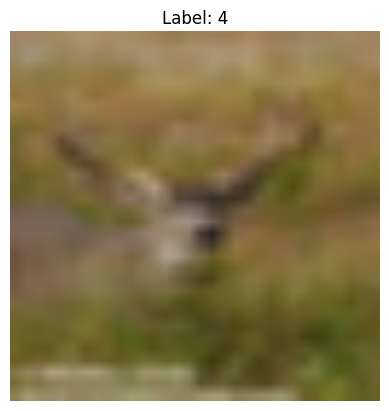

The size of an image is torch.Size([3, 224, 224])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# Call the function with the train_loader
show_image_and_values(train_loader)

#Training and testing

In [ ]:
# Checks whether training should stop early to prevent overfitting or excessive computation.
# This function compares the current validation loss with the best recorded validation loss. If no improvement is observed within the allowed patience (number of epochs), it signals that training should stop early.
def early_stop_check(patience, best_val_loss, best_val_loss_epoch, current_val_loss, current_val_loss_epoch):
    early_stop_flag = False  # Initialize flag to be False
    if current_val_loss < best_val_loss:
        # Update the parameters holding the best validation loss details
        best_val_loss = current_val_loss
        best_val_loss_epoch = current_val_loss_epoch
    else:
        # Check if more than acceptable epochs have passed without improvement
        if current_val_loss_epoch - best_val_loss_epoch > patience:
            early_stop_flag = True  # Change flag
    return best_val_loss, best_val_loss_epoch, early_stop_flag

In [ ]:
def train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs, patience, trial):
    best_val_loss = float('inf')  # Initialize best validation loss
    best_val_loss_epoch = 0  # Track epoch with the best validation loss
    early_stop_flag = False
    best_model_state = None  # To save the best model in each trial, we could have defined it to same the model after each epoch, save only the best one, and so on...

    for epoch in range(1, epochs + 1):
        model.train()  # Enable training mode
        train_loss = 0.0 # Initializing the cumulative training loss for the current epoch to 0.
        total_train_samples = 0 # Initializing the counter for the total number of training samples processed in the current epoch.
        correct_train_predictions = 0 # Initializing the counter for the total number of correctly predicted training samples.

        for inputs, labels in train_loader: #Iterates over the train_loader, which is a DataLoader object containing batches of training data. Each iteration yields a batch of inputs (images) and corresponding labels (ground-truth classes).
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights using the optimizer

            # Accumulate training loss
            train_loss += loss.item() * inputs.size(0)
            total_train_samples += inputs.size(0)

            # Calculate correct predictions for training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss /= total_train_samples
        train_accuracy = correct_train_predictions / total_train_samples

        # Validation loop
        model.eval()  # Enable evaluation mode
        val_loss = 0.0 # Same initialization as in the train
        total_val_samples = 0 # Same initialization as in the train
        correct_val_predictions = 0 # Same initialization as in the train

        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in val_loader: # iterate on the val_loader's batches
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

                # Calculate correct predictions for validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val_predictions += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= total_val_samples
        val_accuracy = correct_val_predictions / total_val_samples

        # Check for early stopping
        best_val_loss, best_val_loss_epoch, early_stop_flag = early_stop_check(patience, best_val_loss, best_val_loss_epoch, val_loss, epoch)

        # Save the best model under the best_model_state parameter
        if val_loss == best_val_loss:
            best_model_state = model.state_dict()

        # Log metrics to Weights & Biases - THIS IS WHERE WE TRACK THE RESULTS AND THE PROCESS
        wandb.log({ #log == logging of the training process (e.g. results)
            "Epoch": epoch,
            "Train Loss": train_loss,
            "Train Accuracy": train_accuracy,
            "Validation Loss": val_loss,
            "Validation Accuracy": val_accuracy
        })

        if early_stop_flag: # Checks whether the early stopping condition has been met, as indicated by the early_stop_flag
            break # Exits the training loop immediately if the early stopping condition is satisfied

    # Save the best model as a .pt file
    if best_model_state is not None: # basically just makes sure that there is a better model (if there is an error the val loss will remain -inf)
        torch.save(best_model_state, f"best_model_trial_{trial.number}.pt") # Save into the same directory

    return best_val_loss

## Optuna functions


In [ ]:
# Optuna objective function
def objective(trial):
    # Hyperparameter suggestions
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3) #Suggests a learning_rate value from a log-uniform distribution between 1e-5 and 1e-3 for hyperparameter optimization using Optuna.
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4) # Suggests a weight_decay value from a log-uniform distribution between 1e-6 and 1e-4 for regularization during Optuna hyperparameter optimization.
    patience = trial.suggest_int("patience", 3, 10) #I don't really like putting the patience as an hyper parameter - this is a thing that needs to be determined according to constraints. I put it here just to show that this is possible.
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16) # Basically choosing between 16,32,48, 64

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Load the train DataLoader with the chosen batch_size
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Load the val DataLoader with the chosen batch_size

    # Load the pre-trained model ResNet18
    model = models.resnet(pretrained=True)
    model = model.to(device)

    # Freeze all parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of in_features for the last fully connected layer of ResNet18
    num_ftrs = model.fc.in_features
    # Replace the last layer with a new one for 10 classes (CIFAR-10)
    # By default, the parameters of this newly created layer will have requires_grad=True
    model.fc = nn.Linear(num_ftrs, 10)
    model.fc = model.fc.to(device)

    # Define optimizer and loss function
    criterion = nn.CrossEntropyLoss() # Classification.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Adam, like always, with the chosen parameters from Optuna

    # Initialize Weights & Biases - the values in the config are the properties of each trial.
    wandb.init(project="ResNet-CIFAR10-EX7", #init == set the project and the "general" parameters
               config={
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "patience": patience,
        "batch_size": batch_size,
        "architecture": "ResNet18",
        "dataset": "CIFAR-10"
    },
    name=f"trial_{trial.number}") # The name that will be saved in the W&B platform

    # Train the model and get the best validation loss
    best_val_loss = train_model_with_hyperparams(model, train_loader, val_loader, optimizer, criterion, epochs=5, patience=patience, trial=trial) #send this trinal to the function above

    # Finish the Weights & Biases run
    wandb.finish()

    # Return best validation loss as the objective to minimize
    return best_val_loss

In [ ]:
# Define and optimize the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) # 20 trials

[I 2025-12-15 12:13:30,963] A new study created in memory with name: no-name-5a6bb1c4-e3b2-448d-bf57-61ae9143f447
/tmp/ipython-input-3103505376.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3) #Suggests a learning_rate value from a log-uniform distribution between 1e-5 and 1e-3 for hyperparameter optimization using Optuna.
/tmp/ipython-input-3103505376.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-4) # Suggests a weight_decay value from a log-uniform distribution between 1e-6 and 1e-4 for regularization during Optuna hyperparame

Epoch,▁▃▅▆█
Train Accuracy,▁▅▇██
Train Loss,█▅▃▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▅▃▂▁
Epoch,5
Train Accuracy,0.72578
Train Loss,1.0194
Validation Accuracy,0.7338
Validation Loss,0.9614


[I 2025-12-15 12:26:27,356] Trial 0 finished with value: 0.9614017864227294 and parameters: {'learning_rate': 2.574600566801749e-05, 'weight_decay': 4.233367355760878e-06, 'patience': 4, 'batch_size': 64}. Best is trial 0 with value: 0.9614017864227294.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.7903
Train Loss,0.62313
Validation Accuracy,0.7998
Validation Loss,0.5906


[I 2025-12-15 12:38:24,502] Trial 1 finished with value: 0.5906027391433716 and parameters: {'learning_rate': 0.00019416148043564273, 'weight_decay': 1.4835011062037723e-05, 'patience': 3, 'batch_size': 32}. Best is trial 1 with value: 0.5906027391433716.


Epoch,▁▃▅▆█
Train Accuracy,▁▆███
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.78966
Train Loss,0.60348
Validation Accuracy,0.8032
Validation Loss,0.5763


[I 2025-12-15 12:50:08,767] Trial 2 finished with value: 0.5762987302303314 and parameters: {'learning_rate': 0.0003911217007381884, 'weight_decay': 1.8500930928873405e-06, 'patience': 7, 'batch_size': 32}. Best is trial 2 with value: 0.5762987302303314.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.796
Train Loss,0.59982
Validation Accuracy,0.801
Validation Loss,0.59219


[I 2025-12-15 13:03:06,708] Trial 3 finished with value: 0.5921850155830384 and parameters: {'learning_rate': 0.000276185868798188, 'weight_decay': 1.6529059871415726e-06, 'patience': 7, 'batch_size': 64}. Best is trial 2 with value: 0.5762987302303314.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.77452
Train Loss,0.68256
Validation Accuracy,0.7878
Validation Loss,0.64534


[I 2025-12-15 13:14:53,818] Trial 4 finished with value: 0.6453410592079163 and parameters: {'learning_rate': 8.727105144285236e-05, 'weight_decay': 2.2310558383494168e-05, 'patience': 4, 'batch_size': 32}. Best is trial 2 with value: 0.5762987302303314.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.74734
Train Loss,0.77552
Validation Accuracy,0.7757
Validation Loss,0.68739


[I 2025-12-15 13:26:42,372] Trial 5 finished with value: 0.6873860343456268 and parameters: {'learning_rate': 4.4384101410264233e-05, 'weight_decay': 1.3908000235804645e-06, 'patience': 5, 'batch_size': 16}. Best is trial 2 with value: 0.5762987302303314.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▄▃█▅
Validation Loss,█▇▇▁▅
Epoch,5
Train Accuracy,0.77112
Train Loss,0.66606
Validation Accuracy,0.798
Validation Loss,0.59799


[I 2025-12-15 13:38:44,390] Trial 6 finished with value: 0.5714068886876106 and parameters: {'learning_rate': 0.0009056896138107123, 'weight_decay': 7.416903202204873e-06, 'patience': 8, 'batch_size': 16}. Best is trial 6 with value: 0.5714068886876106.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▄▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▃▂▁
Epoch,5
Train Accuracy,0.72616
Train Loss,0.90358
Validation Accuracy,0.7519
Validation Loss,0.80217


[I 2025-12-15 13:50:49,609] Trial 7 finished with value: 0.8021705923080444 and parameters: {'learning_rate': 2.105454250990499e-05, 'weight_decay': 4.5176192894764536e-05, 'patience': 3, 'batch_size': 16}. Best is trial 6 with value: 0.5714068886876106.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.7787
Train Loss,0.67396
Validation Accuracy,0.784
Validation Loss,0.64848


[I 2025-12-15 14:02:36,793] Trial 8 finished with value: 0.6484792594909667 and parameters: {'learning_rate': 0.00010266824979869205, 'weight_decay': 1.0032119172598362e-06, 'patience': 10, 'batch_size': 48}. Best is trial 6 with value: 0.5714068886876106.


Epoch,▁▃▅▆█
Train Accuracy,▁▆███
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▆██
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.77488
Train Loss,0.65515
Validation Accuracy,0.8037
Validation Loss,0.57926


[I 2025-12-15 14:14:54,950] Trial 9 finished with value: 0.5792636342525482 and parameters: {'learning_rate': 0.0002909337394127453, 'weight_decay': 2.215663775336128e-05, 'patience': 3, 'batch_size': 16}. Best is trial 6 with value: 0.5714068886876106.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.80206
Train Loss,0.57732
Validation Accuracy,0.8062
Validation Loss,0.5675


[I 2025-12-15 14:26:51,627] Trial 10 finished with value: 0.5674969710588456 and parameters: {'learning_rate': 0.0008132735962430188, 'weight_decay': 5.840477689519996e-06, 'patience': 9, 'batch_size': 48}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▄▄▅█
Validation Loss,█▄▄▁▁
Epoch,5
Train Accuracy,0.80098
Train Loss,0.57801
Validation Accuracy,0.8033
Validation Loss,0.57903


[I 2025-12-15 14:38:44,662] Trial 11 finished with value: 0.5790256352186203 and parameters: {'learning_rate': 0.0007482894791164449, 'weight_decay': 6.67317441888525e-06, 'patience': 9, 'batch_size': 48}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▄▆█▃
Validation Loss,█▅▃▁▅
Epoch,5
Train Accuracy,0.80068
Train Loss,0.57852
Validation Accuracy,0.7926
Validation Loss,0.60244


[I 2025-12-15 14:50:36,252] Trial 12 finished with value: 0.57243957092762 and parameters: {'learning_rate': 0.000903527847210373, 'weight_decay': 4.679532219142343e-06, 'patience': 9, 'batch_size': 48}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▂▁▁▁
Validation Accuracy,▁▄▇▆█
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.7987
Train Loss,0.58296
Validation Accuracy,0.8045
Validation Loss,0.57385


[I 2025-12-15 15:02:29,178] Trial 13 finished with value: 0.5738469679355621 and parameters: {'learning_rate': 0.00058939600354467, 'weight_decay': 9.630076713008639e-06, 'patience': 8, 'batch_size': 48}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▅▇▇█
Train Loss,█▅▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▅▃▂▁
Epoch,5
Train Accuracy,0.6648
Train Loss,1.2599
Validation Accuracy,0.6921
Validation Loss,1.16032


[I 2025-12-15 15:14:27,482] Trial 14 finished with value: 1.160315131187439 and parameters: {'learning_rate': 1.0542383967020656e-05, 'weight_decay': 3.582543347925748e-06, 'patience': 10, 'batch_size': 32}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.80244
Train Loss,0.57666
Validation Accuracy,0.8055
Validation Loss,0.57608


[I 2025-12-15 15:27:47,555] Trial 15 finished with value: 0.5760800255775451 and parameters: {'learning_rate': 0.0004814994907922699, 'weight_decay': 6.106733085767125e-05, 'patience': 8, 'batch_size': 64}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▆▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▃▂▁
Epoch,5
Train Accuracy,0.77282
Train Loss,0.67513
Validation Accuracy,0.7979
Validation Loss,0.59508


[I 2025-12-15 15:40:07,336] Trial 16 finished with value: 0.5950840996026993 and parameters: {'learning_rate': 0.00015041329607493262, 'weight_decay': 8.837556380918509e-06, 'patience': 6, 'batch_size': 16}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▇▅█
Validation Loss,█▄▂▅▁
Epoch,5
Train Accuracy,0.79298
Train Loss,0.59553
Validation Accuracy,0.8082
Validation Loss,0.56959


[I 2025-12-15 15:52:06,450] Trial 17 finished with value: 0.5695862659454346 and parameters: {'learning_rate': 0.000886347475482736, 'weight_decay': 2.4013280480084046e-06, 'patience': 8, 'batch_size': 32}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▂▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▁▁
Epoch,5
Train Accuracy,0.7977
Train Loss,0.58796
Validation Accuracy,0.8043
Validation Loss,0.58181


[I 2025-12-15 16:04:00,999] Trial 18 finished with value: 0.581809459066391 and parameters: {'learning_rate': 0.00041006779688342244, 'weight_decay': 2.8548818442642025e-06, 'patience': 9, 'batch_size': 48}. Best is trial 10 with value: 0.5674969710588456.


Epoch,▁▃▅▆█
Train Accuracy,▁▇▇██
Train Loss,█▃▂▁▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▂▁
Epoch,5
Train Accuracy,0.76678
Train Loss,0.71486
Validation Accuracy,0.7826
Validation Loss,0.66173


[I 2025-12-15 16:15:51,107] Trial 19 finished with value: 0.6617279583454132 and parameters: {'learning_rate': 6.660754419964326e-05, 'weight_decay': 2.4049364694422923e-06, 'patience': 6, 'batch_size': 32}. Best is trial 10 with value: 0.5674969710588456.


### Get the best hyperparameters from Optuna study

In [ ]:
best_trial = study.best_trial

print(f"Best trial number: {best_trial.number}")
print(f"Best validation loss: {best_trial.value}")

print("Best hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

best_learning_rate = best_trial.params['learning_rate']
best_weight_decay = best_trial.params['weight_decay']
best_patience = best_trial.params['patience']
best_batch_size = best_trial.params['batch_size']

Best trial number: 10
Best validation loss: 0.5674969710588456
Best hyperparameters:
  learning_rate: 0.0008132735962430188
  weight_decay: 5.840477689519996e-06
  patience: 9
  batch_size: 48


### Train the model with the best hyperparameters for 50 epochs

In [ ]:
# Load the pre-trained model ResNet18
model_final = models.resnet18(pretrained=True)
model_final = model_final.to(device)

# Freeze all parameters in the model
for param in model_final.parameters():
    param.requires_grad = False

# Get the number of in_features for the last fully connected layer of ResNet18
num_ftrs_final = model_final.fc.in_features
# Replace the last layer with a new one for 10 classes (CIFAR-10)
model_final.fc = nn.Linear(num_ftrs_final, 10)
model_final.fc = model_final.fc.to(device)

# Define optimizer and loss function with best hyperparameters
criterion_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(model_final.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

# DataLoaders with best batch size
train_loader_final = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader_final = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Initialize Weights & Biases for the final run
wandb.init(project="ResNet-CIFAR10-EX7",
           config={
    "learning_rate": best_learning_rate,
    "weight_decay": best_weight_decay,
    "patience": best_patience,
    "batch_size": best_batch_size,
    "architecture": "ResNet18",
    "dataset": "CIFAR-10",
    "epochs": 50 # Final training epochs
},
name="Final_Training_Run")

# Train the model with the best hyperparameters for 50 epochs
best_val_loss_final = train_model_with_hyperparams(model_final, train_loader_final, val_loader_final, optimizer_final, criterion_final, epochs=50, patience=best_patience, trial=best_trial)

print(f"Final model trained with best hyperparameters. Best validation loss: {best_val_loss_final}")

# Finish the Weights & Biases run
wandb.finish()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
